In [1]:
%pip install -qq HTSeq
from collections import Counter

# Current Issue of EasySci

1. Double counting if paired-end reads are in the same exon
2. Count definite paired reads ambiguously
3. Exon junction reads are discarded

In [2]:
# # Import EasySci Exon Counting
# - Use mod.count_read(first_almnt, second_almnt, exons, counter)
# - Count will be divided by 2 when merging

import sys, tempfile, urllib.request, importlib.util, os

# 1. URL of the raw .py file you want to pull in
url = "https://raw.githubusercontent.com/JunyueCaoLab/EasySci/refs/heads/main/script_folder/exon_counting_paired.py"

# 2. Download it
with urllib.request.urlopen(url) as resp:
    code_bytes = resp.read()

# 3. Save it to a temporary file (keeps your project tree clean)
tmp_path = tempfile.NamedTemporaryFile(delete=False, suffix=".py").name
with open(tmp_path, "wb") as f:
    f.write(code_bytes)

# 4. Turn that file into an importable module object
module_name = "EasySci"                       # whatever name you want in `import` space
spec = importlib.util.spec_from_file_location(module_name, tmp_path)
mod  = importlib.util.module_from_spec(spec)
sys.modules[module_name] = mod                 # lets `import mymodule` work elsewhere
spec.loader.exec_module(mod)

In [ ]:
# My new functions `count_pair_new`
def reverse_strand(algn):
    """
    Reverse the strand of an alignment and its cigar operations' reference intervals (in-place)
    """
    # algn is reference, so we can change it in-place, no need to return
    algn.iv.strand = "-" if algn.iv.strand == "+" else "+"
    for op in algn.cigar:
        op.ref_iv.strand = algn.iv.strand

def get_exon_reads_exons(algn, exons)-> set:
    """
    Only count reads in exons (no introns or junctions)
    """
    algn_exons = set()
    first_run = True
    for op in algn.cigar:
        if op.type != "M":
            continue
        for iv, exon in exons[op.ref_iv].steps():
            if first_run:
                algn_exons |= exon
                first_run = False
            else:
                algn_exons &= exon
    return algn_exons

# Used in balanced exon counting
def count_pair_new(algn_pair, exons, exon_gene_dict, counter):
    """
    Count exon reads in a pair of alignments
    """
    if not algn_pair[0].aligned or not algn_pair[1].aligned:
        counter["_unmapped"] += 1 # Just in case, since we only have primary alignments
        return
        # Because Counter is a reference here, we don't need to return it.
    if algn_pair[0].iv.chrom not in exons.chrom_vectors or algn_pair[1].iv.chrom not in exons.chrom_vectors:
        counter["_unmapped"] += 1 # Just in case, since we use the same GTF file for alignment and counting
        return

    # Because of the Illumina sequencing and library preparation.
    #   1st read is always anti-sense to the gene(mRNA), while 2nd read is sense.
    reverse_strand(algn_pair[0])
    first_algn_exons = get_exon_reads_exons(algn_pair[0], exons)
    second_algn_exons = get_exon_reads_exons(algn_pair[1], exons)

    # Checking the opposite strand mapping. If no match on expected strand
    if len(first_algn_exons) == 0 and len(second_algn_exons) == 0:
        reverse_strand(algn_pair[0])
        first_algn_exons = get_exon_reads_exons(algn_pair[0], exons)
        reverse_strand(algn_pair[1])
        second_algn_exons = get_exon_reads_exons(algn_pair[1], exons)

    # If still not matched, then _no_feature
    if len(first_algn_exons) == 0 and len(second_algn_exons) == 0:
        counter["_no_feature"] += 1
        return

    elif len(first_algn_exons) == 0: # len(second_algn_exons) > 0
        counter["_no_feature"] += 1
        second_algn_genes = set(exon_gene_dict[exon] for exon in second_algn_exons)
        if len(second_algn_genes) == 1:
            for exon_id in second_algn_exons:
                counter[exon_id] += 1 / len(second_algn_exons)
        else:
            counter["_ambiguous"] += 1
        return

    elif len(second_algn_exons) == 0: # len(first_algn_exons) > 0
        counter["_no_feature"] += 1
        first_algn_genes = set(exon_gene_dict[exon] for exon in first_algn_exons)
        if len(first_algn_genes) == 1:
            for exon_id in first_algn_exons:
                counter[exon_id] += 1 / len(first_algn_exons)
        else:
            counter["_ambiguous"] += 1
        return

    first_algn_genes = set(exon_gene_dict[exon] for exon in first_algn_exons)
    second_algn_genes = set(exon_gene_dict[exon] for exon in second_algn_exons)

    intersect_genes = first_algn_genes & second_algn_genes
    if len(intersect_genes) == 1:
        first_algn_exons_filtered = set(exon_id for exon_id in first_algn_exons if exon_gene_dict[exon_id] == next(iter(intersect_genes)))
        second_algn_exons_filtered = set(exon_id for exon_id in second_algn_exons if exon_gene_dict[exon_id] == next(iter(intersect_genes)))

        intersect_exons = first_algn_exons_filtered & second_algn_exons_filtered
        if intersect_exons:
            for exon_id in intersect_exons:
                counter[exon_id] += 1 / len(intersect_exons)
            return

        # Not in the same exon => count separately
        if first_algn_exons_filtered:
            for exon_id in first_algn_exons_filtered:
                counter[exon_id] += 1 / len(first_algn_exons_filtered)
        else:
            counter["_ambiguous"] += 1
        if second_algn_exons_filtered:
            for exon_id in second_algn_exons_filtered:
                counter[exon_id] += 1 / len(second_algn_exons_filtered)
        else:
            counter["_ambiguous"] += 1
    else:
        counter["_ambiguous"] += 1


In [4]:
def count_pair_with_junctions(algn_pair, exons, exon_gene_dict, counter):
    """
    Count exon reads in a pair of alignments with junctions
    """
    if not algn_pair[0].aligned or not algn_pair[1].aligned:
        counter["_unmapped"] += 1 # Just in case, since we only have primary alignments
        return
        # Because Counter is a reference here, we don't need to return it.

    if algn_pair[0].iv.chrom not in exons.chrom_vectors or algn_pair[1].iv.chrom not in exons.chrom_vectors:
        counter["_unmapped"] += 1 # Just in case, since we use the same GTF file for alignment and counting
        return

    reverse_strand(algn_pair[0]) # You need to do this because of the Illumina sequencing and library preparation.

    # Make sure first alignment is the one that starts first on the genome
    if algn_pair[0].iv.start < algn_pair[1].iv.start:
        first_algn, second_algn = algn_pair[0], algn_pair[1]
    else:
        first_algn, second_algn = algn_pair[1], algn_pair[0]

    first_algn_blocks_and_genes = get_exon_junction_reads_blocks(first_algn, exons, exon_gene_dict)
    second_algn_blocks_and_genes = get_exon_junction_reads_blocks(second_algn, exons, exon_gene_dict)
    # The blocks is a tuple of:
    # - [0] exon blocks: list of sets where each set contains gene_exon_id from the same block
    #   - Each block is separated by "N" in the CIGAR string.
    # - [1] intersection genes: set of genes that all blocks have in common (skip empty blocks)
    # - [2] union genes: set of all genes that are present in any of the blocks
    # - [3] coordinates: list of tuples [start, end) for each block (0-based, end exclusive)

    # any to all
    if all(len(block) == 0 for block in first_algn_blocks_and_genes[0]) and all(len(block) == 0 for block in second_algn_blocks_and_genes[0]):
        # No feature found in both reads, try the opposite strand
        reverse_strand(first_algn)
        first_algn_blocks_and_genes = get_exon_junction_reads_blocks(first_algn, exons, exon_gene_dict)
        reverse_strand(second_algn)
        second_algn_blocks_and_genes = get_exon_junction_reads_blocks(second_algn, exons, exon_gene_dict)

    # If still not matched, then _no_feature
    if all(len(block) == 0 for block in first_algn_blocks_and_genes[0]) and all(len(block) == 0 for block in second_algn_blocks_and_genes[0]):
        counter["_no_feature"] += 1
        return

    elif len(first_algn_blocks_and_genes[0]) == 0: # len(second_algn_blocks_and_genes[0]) > 0
        if len(second_algn_blocks_and_genes[1]) == 1: # only one gene
            count_exon_blocks_using_gene(counter, exon_gene_dict, next(iter(second_algn_blocks_and_genes[1])), second_algn_blocks_and_genes[0])
        elif len(second_algn_blocks_and_genes[2]) == 1:
            count_exon_blocks_using_gene(counter, exon_gene_dict, next(iter(second_algn_blocks_and_genes[2])), second_algn_blocks_and_genes[0])
        else:
            counter["_ambiguous"] += 1
        return

    elif len(second_algn_blocks_and_genes[0]) == 0: # len(first_algn_blocks_and_genes[0]) > 0
        if len(first_algn_blocks_and_genes[1]) == 1: # only one gene
            count_exon_blocks_using_gene(counter, exon_gene_dict, next(iter(first_algn_blocks_and_genes[1])), first_algn_blocks_and_genes[0])
        elif len(first_algn_blocks_and_genes[2]) == 1:
            count_exon_blocks_using_gene(counter, exon_gene_dict, next(iter(first_algn_blocks_and_genes[2])), first_algn_blocks_and_genes[0])
        else:
            counter["_ambiguous"] += 1
        return

    # If both reads have more than 0 blocks, then we need to check the intersection of genes
    common_genes = first_algn_blocks_and_genes[1] & second_algn_blocks_and_genes[1]
    if len(common_genes) != 1:
        common_genes = first_algn_blocks_and_genes[1] & second_algn_blocks_and_genes[2]
    if len(common_genes) != 1:
        common_genes = first_algn_blocks_and_genes[2] & second_algn_blocks_and_genes[1]
    if len(common_genes) != 1:
        common_genes = first_algn_blocks_and_genes[2] & second_algn_blocks_and_genes[2]
    if len(common_genes) != 1:
        counter["_ambiguous"] += 1
        return

    # Try to see there are overlap blocks
    # If first end > second start, then they overlap
    blocks_to_count = []
    if first_algn.iv.end <= second_algn.iv.start:
        # No overlap, try to see if there is any common exons on the edges
        common_exons = first_algn_blocks_and_genes[0][-1] & second_algn_blocks_and_genes[0][0]
        if common_exons:
            blocks_to_count.append(common_exons)
            # Skip the last block of the first read and the first block of the second read
            if len(first_algn_blocks_and_genes[0]) > 1:
                blocks_to_count.extend(first_algn_blocks_and_genes[0][:-1])
            if len(second_algn_blocks_and_genes[0]) > 1:
                blocks_to_count.extend(second_algn_blocks_and_genes[0][1:])
        else:
            blocks_to_count.extend(first_algn_blocks_and_genes[0])
            blocks_to_count.extend(second_algn_blocks_and_genes[0])
    else:
        skip_indices_first = []
        skip_indices_second = []
        for i in range(len(first_algn_blocks_and_genes[0])):
            for j in range(len(second_algn_blocks_and_genes[0])):
                common_exons = first_algn_blocks_and_genes[0][i] & second_algn_blocks_and_genes[0][j]
                if common_exons:
                    blocks_to_count.append(common_exons)
                    # Skip the block of the first read and the second read
                    skip_indices_first.append(i)
                    skip_indices_second.append(j)

        blocks_to_count.extend(
            first_algn_blocks_and_genes[0][i] for i in range(len(first_algn_blocks_and_genes[0])) if i not in skip_indices_first
        )
        blocks_to_count.extend(
            second_algn_blocks_and_genes[0][j] for j in range(len(second_algn_blocks_and_genes[0])) if j not in skip_indices_second
        )

    count_exon_blocks_using_gene(counter, exon_gene_dict, next(iter(common_genes)), blocks_to_count)

def get_exon_junction_reads_blocks(algn, exons, exon_gene_dict)-> tuple[list[set], set, set]:
    """
    For a given alignment, return a list of exon sets.
    Each set corresponds to a continuous aligned block (separated by N in the CIGAR string).

    - algn: HTSeq.Alignment object
    - exons: HTSeq.GenomicArrayOfSets of all gene_id-exon_id

    return a tuple of:
    - [0] exon blocks: list of sets where each set contains gene_exon_id from the same block
        - Each block is separated by "N" in the CIGAR string.
    - [1] intersection genes: set of genes that all blocks have in common (skip empty blocks)
    - [2] union genes: set of all genes that are present in any of the blocks
    """
    exon_blocks = []
    intersection_genes = set()
    union_genes = set()

    current_exons = set()
    is_first_op = True

    for op in algn.cigar:
        if op.type == "N":  # Spliced region (e.g., intron)
            exon_blocks.append(current_exons)
            # Reset for the next block
            current_exons = set()
            is_first_op = True
            continue

        if op.type != "M":
            continue

        for iv, exon_ids in exons[op.ref_iv].steps():
            if is_first_op:
                current_exons |= exon_ids
                is_first_op = False
            else:
                current_exons &= exon_ids

    exon_blocks.append(current_exons)

    # Get genes from the blocks (except empty blocks)
    blocks_genes = [set(exon_gene_dict[exon] for exon in block) for block in exon_blocks if block]
    if blocks_genes:
        intersection_genes = set.intersection(*blocks_genes)
        union_genes = set.union(*blocks_genes)

    return (exon_blocks, intersection_genes, union_genes)

def count_exon_blocks_using_gene(counter, exon_gene_dict, gene, exon_blocks: list[set], multiplier = 1):
    """
    Count exon blocks using the gene name
    - counter: collections.Counter object to store counts
    - exon_gene_dict: dict mapping gene_exon_id to gene_id
    - gene: gene name (e.g., "ENSG00000123456")
    - exon_blocks: list of sets where each set contains gene_exon_id from the same block
    """
    is_counted = False

    for block in exon_blocks:
        block_exons_from_the_same_gene = [exon for exon in block if exon_gene_dict[exon] == gene]
        if block_exons_from_the_same_gene:
            for exon in block_exons_from_the_same_gene:
                is_counted = True
                counter[exon] += multiplier / len(block_exons_from_the_same_gene)

    if not is_counted:
        counter["_ambiguous"] += 1  # If no exons from the same gene are found, count as ambiguous


# Utility Functions

- Generate mock genome `create_stranded_mock_genome()`
- Generate fake read `create_fake_alignment("exon_read", "chr1", "+", 126, "50M")`
- Plot the Chromosome `chrom_plt("chr1")`
- Plot the Alignment `algn_pair_plt([read1, read2])`


In [5]:
import re, os, HTSeq
from typing import List, Tuple, Dict

def create_fake_alignment(name, chrom, strand, start, cigar):
    """
    Creates a fake HTSeq.GenomicAlignment object based on provided parameters.

    Args:
        name (str): The read name.
        chrom (str): The chromosome name (e.g., 'chr1').
        strand (str): The strand ('+' or '-').
        start (int): The 1-based start position on the chromosome.
        cigar (str): The CIGAR string (e.g., '20M20N20M').

    Returns:
        HTSeq.GenomicAlignment: A fake alignment object.
    """

    # 1. Parse CIGAR to determine sequence length
    # 'M', 'I', '=', 'X', 'S', 'P', 'H' operations consume sequence bases.
    # 'D', 'N' do not.
    sequence_length = 0
    cigar_operations = re.findall(r'(\d+)([MIDNSHP=X])', cigar)
    for length, op in cigar_operations:
        if op in ['M', 'I', '=', 'X', 'S', 'P', 'H']: # Operations that consume sequence bases
            sequence_length += int(length)

    # Create dummy sequence and quality strings based on calculated length
    seq_str = "A" * sequence_length
    qual_str = "F" * sequence_length

    # 2. Determine SAM flag based on strand
    # SAM flag 0: forward strand, no other flags set
    # SAM flag 16: reverse strand, no other flags set
    # Other flags (e.g., paired-end, unmapped) are not considered here for simplicity
    sam_flag = 0
    if strand == '-':
        sam_flag = 16
    elif strand != '+':
        print(f"Warning: Invalid strand '{strand}'. Defaulting to '+' strand (flag 0).")


    # 3. Construct the SAM text
    # The header line is static for a single chromosome example.
    # The alignment line uses the provided parameters and calculated sequence/quality.
    # RNAME is the name of the reference sequence (chromosome).
    # POS is the 1-based leftmost mapping position of the first matching base.
    # TLEN (template length) and RNEXT (next reference name) are set to '*' and '0' for a single-end read.
    sam_text = (
        f'@SQ\tSN:{chrom}\tLN:100000000\n' + # Arbitrary large length for chromosome
        f'{name}\t{sam_flag}\t{chrom}\t{start}\t255\t{cigar}\t*\t0\t0\t{seq_str}\t{qual_str}\n'
    )

    temp_sam_file = ".tmp.sam"
    try:
        # Write the SAM text to a temporary file
        with open(temp_sam_file, "w") as f:
            f.write(sam_text)

        # Use HTSeq.SAM_Reader to parse the temporary file
        with HTSeq.SAM_Reader(temp_sam_file, "r") as sam_reader:
            for algn in sam_reader:
                return algn
    finally:
        # Ensure the temporary file is deleted even if an error occurs
        if os.path.exists(temp_sam_file):
            os.remove(temp_sam_file)

In [6]:
def convert_to_1based_intervals(exons_info: List[Tuple[str, str, str, HTSeq.GenomicInterval]]) -> List[Tuple[str, str, str, Tuple[int, int, str]]]:
    """
    Convert 0-based GenomicInterval to 1-based inclusive coordinates.

    Args:
        exons_info (List[Tuple[str, str, str, HTSeq.GenomicInterval]]): List of (gene_id, transcript_id, exon_id, interval).

    Returns:
        List of (gene_id, transcript_id, exon_id, (start_1based, end_1based, strand)) tuples.
    """
    converted = []
    for gene_id, transcript_id, exon_id, iv in exons_info:
        # 0-based start -> 1-based start: add 1
        # 0-based end (exclusive) -> 1-based end (inclusive): no change
        start_1based = iv.start + 1
        end_1based = iv.end
        converted.append((gene_id, transcript_id, exon_id, (start_1based, end_1based, iv.strand)))
    return converted

import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

def plot_exons(chrom: str, exons: HTSeq.GenomicArrayOfSets, exons_info: List[Tuple[str, str, str, HTSeq.GenomicInterval]], figsize = (12, 6)) -> None:
    """
    Plot exon intervals for a given chromosome with 1-based inclusive coordinates, grouping exons by transcript as rows in a single plot.
    Uses blue for + strand and red for - strand, with arrows between exons to indicate strand direction.

    Args:
        chrom (str): Chromosome name (e.g., 'chr1').
        exons (HTSeq.GenomicArrayOfSets): Exon intervals with stranded=True.
        exons_info (List[Tuple[str, str, str, HTSeq.GenomicInterval]]): List of (gene_id, transcript_id, exon_id, interval).
    """
    # Convert intervals to 1-based inclusive coordinates
    intervals_1based = []
    for gene_id, transcript_id, exon_id, (start_1based, end_1based, strand) in convert_to_1based_intervals(exons_info):
        if chrom == "chr1":  # Filter for the specified chromosome
            gene_exon_id = f"{gene_id}-{exon_id}"
            intervals_1based.append((start_1based, end_1based, strand, exon_id, f"{gene_id}-{transcript_id}"))

    if not intervals_1based:
        print(f"No exons found for chromosome {chrom}")
        return

    # Group intervals by transcript
    transcripts = {}
    for start, end, strand, exon_id, transcript_id in intervals_1based:
        if transcript_id not in transcripts:
            transcripts[transcript_id] = []
        transcripts[transcript_id].append((start, end, strand, exon_id))

    # Sort transcripts alphabetically for consistent plotting
    transcript_list = sorted(transcripts.keys())

    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot exons and arrows for each transcript
    for i, transcript_id in enumerate(transcript_list):
        # Sort exons by start for + strand, by end for - strand (to reflect 5' to 3' direction)
        strand = transcripts[transcript_id][0][2]  # Get strand from first exon
        sorted_exons = sorted(
            transcripts[transcript_id],
            key=lambda x: x[0] # if strand == '+' else -x[1]  # Sort by start for +, end for - (reversed)
        )

        # Plot exons
        for start, end, strand, exon_id in sorted_exons:
            color = 'blue' if strand == '+' else 'red'
            ax.plot([start, end], [i, i], color=color, linewidth=5)
            ax.text(start, i + 0.2, f"{exon_id}:[{start},{end}]", fontsize=8, verticalalignment='bottom')

        # Plot arrows between consecutive exons
        if len(sorted_exons) > 1:  # Only draw arrows if there are multiple exons
            for j in range(len(sorted_exons) - 1):
                curr_end = sorted_exons[j][1]  # End of current exon
                next_start = sorted_exons[j + 1][0]  # Start of next exon
                if curr_end < next_start:  # Ensure there’s a gap between exons
                    arrow_x = (curr_end * 0.75 + next_start * 0.25)  if strand == '+' else (curr_end * 0.25 + next_start * 0.75)
                    arrow_dx = (next_start - curr_end) / 2  # Arrow length (1/2 of gap)
                    if strand == '+':
                        ax.arrow(arrow_x, i, arrow_dx, 0, color='blue', head_width=0.1, head_length=10, length_includes_head=True)
                    else:
                        ax.arrow(arrow_x, i, -arrow_dx, 0, color='red', head_width=0.1, head_length=10, length_includes_head=True)

    # Customize the plot
    ax.set_title(f"{chrom} Exons (1-based, inclusive; Blue: +, Red: -)")
    ax.set_ylabel("Transcripts")
    ax.set_xlabel("Genomic Position (1-based)")

    # Set y-ticks to transcript names
    if transcript_list:
        ax.set_yticks(range(len(transcript_list)))
        ax.set_yticklabels(transcript_list)
        ax.set_ylim(-0.5, len(transcript_list) - 0.5)  # Add padding to y-axis
    else:
        ax.set_yticks([])

    # Adjust x-axis limits
    all_starts = [start for start, _, _, _ in sum(transcripts.values(), [])]
    all_ends = [end for _, end, _, _ in sum(transcripts.values(), [])]
    min_pos = min(all_starts) - 50 if all_starts else 0
    max_pos = max(all_ends) + 50 if all_ends else 1000
    ax.set_xlim(min_pos, max_pos)

    fig.tight_layout(pad=2.0)  # Add padding to prevent label clipping
    return fig

In [7]:
def plot_alignment(alignment: HTSeq.SAM_Alignment, exons: HTSeq.GenomicArrayOfSets, genes: HTSeq.GenomicArrayOfSets, exon_gene_dict: Dict[str, str], exons_info: List[Tuple[str, str, str, HTSeq.GenomicInterval]], figsize) -> None:
    """
    Plot exon intervals for genes that overlap with the given SAM alignment’s matched regions, using get_exon_reads_exons to find overlapping exons,
    with 1-based inclusive coordinates, grouping exons by transcript as rows in a single plot.
    Uses blue for + strand and red for - strand, with arrows between exons to indicate strand direction.

    Args:
        alignment (HTSeq.SAM_Alignment): SAM alignment object with iv and cigar attributes (0-based).
        exons (HTSeq.GenomicArrayOfSets): Exon intervals with stranded=True.
        genes (HTSeq.GenomicArrayOfSets): Gene intervals with stranded=True.
        exon_gene_dict (Dict[str, str]): Dictionary mapping exon IDs to gene_id.
        exons_info (List[Tuple[str, str, str, HTSeq.GenomicInterval]]): List of (gene_id, transcript_id, exon_id, interval).
    """
    # Find overlapping exons using get_exon_reads_exons
    overlapping_genes = set()
    for op in alignment.cigar:
        if op.type != "M":
            continue
        for iv, ids in genes[op.ref_iv].steps():
            overlapping_genes |= ids

    if not overlapping_genes:
        print(f"No genes overlap with alignment {alignment.iv.start+1}-{alignment.iv.end}")
        return

    # Filter intervals for overlapping genes and convert to 1-based
    intervals_1based = []
    for gene_id, transcript_id, exon_id, (start_1based, end_1based, strand) in convert_to_1based_intervals(exons_info):
        if gene_id in overlapping_genes:
            gene_exon_id = f"{gene_id}-{exon_id}"
            if gene_exon_id in exon_gene_dict:
                intervals_1based.append((start_1based, end_1based, strand, exon_id, f"{gene_id}-{transcript_id}"))

    if not intervals_1based:
        print(f"No exons found for overlapping genes")
        return

    # Group intervals by transcript
    transcripts = {}
    for start, end, strand, exon_id, transcript_id in intervals_1based:
        if transcript_id not in transcripts:
            transcripts[transcript_id] = []
        transcripts[transcript_id].append((start, end, strand, exon_id))

    # Sort transcripts alphabetically for consistent plotting
    transcript_list = sorted(transcripts.keys())

    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot exons and arrows for each transcript
    for i, transcript_id in enumerate(transcript_list):
        # Sort exons by start for + strand, by end for - strand (to reflect 5' to 3' direction)
        strand = transcripts[transcript_id][0][2]  # Get strand from first exon
        sorted_exons = sorted(
            transcripts[transcript_id],
            key=lambda x: x[0] # if strand == '+' else -x[1]  # Sort by start for +, end for - (reversed)
        )

        # Plot exons
        for start, end, strand, exon_id in sorted_exons:
            color = 'blue' if strand == '+' else 'red'
            ax.plot([start, end], [i, i], color=color, linewidth=5)
            ax.text(start, i + 0.2, f"{exon_id}:[{start},{end}]", fontsize=8, verticalalignment='bottom')

        # Plot arrows between consecutive exons
        if len(sorted_exons) > 1:  # Only draw arrows if there are multiple exons
            for j in range(len(sorted_exons) - 1):
                curr_end = sorted_exons[j][1]  # End of current exon
                next_start = sorted_exons[j + 1][0]  # Start of next exon
                if curr_end < next_start:  # Ensure there’s a gap between exons
                    arrow_x = (curr_end * 0.75 + next_start * 0.25)  if strand == '+' else (curr_end * 0.25 + next_start * 0.75)
                    arrow_dx = (next_start - curr_end) / 2  # Arrow length (1/2 of gap)
                    if strand == '+':
                        ax.arrow(arrow_x, i, arrow_dx, 0, color='blue', head_width=0.1, head_length=10, length_includes_head=True)
                    else:
                        ax.arrow(arrow_x, i, -arrow_dx, 0, color='red', head_width=0.1, head_length=10, length_includes_head=True)

    # Plot alignment interval
    alignment_start = alignment.iv.start + 1  # Convert to 1-based
    alignment_end = alignment.iv.end
    ax.plot([alignment_start, alignment_end], [-1, -1], color='lightgray', linewidth=3)

    # Plot vertical lines for 'M' cigar operation boundaries
    for op in alignment.cigar:
        if op.type != "M":
            continue
        match_start = op.ref_iv.start + 1  # Convert to 1-based
        match_end = op.ref_iv.end + 1 # Include the end
        ax.plot([match_start, match_end], [-1, -1], color='black', linewidth=3)

        ax.axvline(x=match_start, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=match_end, color='gray', linestyle='--', alpha=0.5)

    alginment_cigar = " ".join(f"{op.size}{op.type}" for op in alignment.cigar)
    ax.text(alignment_start, -1 + 0.2, f"Alignment:[{alignment.iv.chrom}{alignment.iv.strand} {alignment_start}: {alginment_cigar}]", fontsize=8, verticalalignment='bottom')

    # Customize the plot
    ax.set_title(f"Alignment [{alignment.iv.chrom}{alignment.iv.strand} {alignment_start}: {alginment_cigar}] (1-based, inclusive; Blue: +, Red: -)")
    ax.set_ylabel("Transcripts")
    ax.set_xlabel("Genomic Position (1-based)")

    # Set y-ticks to transcript names, including alignment row
    y_ticks = list(range(len(transcript_list))) + [-1]
    y_labels = transcript_list + ["Alignment"]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_ylim(-1.5, len(transcript_list) - 0.5)  # Add padding to include alignment row

    # Adjust x-axis limits based on alignment and exons
    all_starts = [start for start, _, _, _ in sum(transcripts.values(), [])] + [alignment.iv.start + 1]
    all_ends = [end for _, end, _, _ in sum(transcripts.values(), [])] + [alignment.iv.end]
    min_pos = min(all_starts) - 50
    max_pos = max(all_ends) + 50
    ax.set_xlim(min_pos, max_pos)

    fig.tight_layout(pad=2.0)  # Add padding to prevent label clipping
    return fig


In [8]:
def plot_alignment_pair(algn_pair: list[HTSeq.SAM_Alignment], exons: HTSeq.GenomicArrayOfSets, genes: HTSeq.GenomicArrayOfSets, exon_gene_dict: Dict[str, str], exons_info: List[Tuple[str, str, str, HTSeq.GenomicInterval]], figsize) -> None:
    """
    Plot exon intervals for genes that overlap with the given SAM alignment’s matched regions, using get_exon_reads_exons to find overlapping exons,
    with 1-based inclusive coordinates, grouping exons by transcript as rows in a single plot.
    Uses blue for + strand and red for - strand, with arrows between exons to indicate strand direction.

    Args:
        algn_pair (list[HTSeq.SAM_Alignment]): list of 2 SAM alignment objects with iv and cigar attributes (0-based).
        exons (HTSeq.GenomicArrayOfSets): Exon intervals with stranded=True.
        genes (HTSeq.GenomicArrayOfSets): Gene intervals with stranded=True.
        exon_gene_dict (Dict[str, str]): Dictionary mapping exon IDs to gene_id.
        exons_info (List[Tuple[str, str, str, HTSeq.GenomicInterval]]): List of (gene_id, transcript_id, exon_id, interval).
    """
    # Reverse strand of the first read (Illumina first read)
    # reverse_strand(algn_pair[0])

    # Find overlapping exons using get_exon_reads_exons
    overlapping_genes = set()
    reverse_strand(algn_pair[0])
    for alignment in algn_pair:
        for op in alignment.cigar:
            if op.type != "M":
                continue
            for iv, ids in genes[op.ref_iv].steps():
                overlapping_genes |= ids

    if not overlapping_genes:
        print(f"No genes overlap with alignments pair")
        return

    # Filter intervals for overlapping genes and convert to 1-based
    intervals_1based = []
    for gene_id, transcript_id, exon_id, (start_1based, end_1based, strand) in convert_to_1based_intervals(exons_info):
        if gene_id in overlapping_genes:
            gene_exon_id = f"{gene_id}-{exon_id}"
            if gene_exon_id in exon_gene_dict:
                intervals_1based.append((start_1based, end_1based, strand, exon_id, f"{gene_id}-{transcript_id}"))

    if not intervals_1based:
        print(f"No exons found for overlapping genes")
        return

    # Group intervals by transcript
    transcripts = {}
    for start, end, strand, exon_id, transcript_id in intervals_1based:
        if transcript_id not in transcripts:
            transcripts[transcript_id] = []
        transcripts[transcript_id].append((start, end, strand, exon_id))

    # Sort transcripts alphabetically for consistent plotting
    transcript_list = sorted(transcripts.keys())

    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot exons and arrows for each transcript
    for i, transcript_id in enumerate(transcript_list):
        # Sort exons by start for + strand, by end for - strand (to reflect 5' to 3' direction)
        strand = transcripts[transcript_id][0][2]  # Get strand from first exon
        sorted_exons = sorted(
            transcripts[transcript_id],
            key=lambda x: x[0] # if strand == '+' else -x[1]  # Sort by start for +, end for - (reversed)
        )

        # Plot exons
        for start, end, strand, exon_id in sorted_exons:
            color = 'blue' if strand == '+' else 'red'
            ax.plot([start, end], [i, i], color=color, linewidth=5)
            ax.text(start, i + 0.2, f"{exon_id}:[{start},{end}]", fontsize=8, verticalalignment='bottom')

        # Plot arrows between consecutive exons
        if len(sorted_exons) > 1:  # Only draw arrows if there are multiple exons
            for j in range(len(sorted_exons) - 1):
                curr_end = sorted_exons[j][1]  # End of current exon
                next_start = sorted_exons[j + 1][0]  # Start of next exon
                if curr_end < next_start:  # Ensure there’s a gap between exons
                    arrow_x = (curr_end * 0.75 + next_start * 0.25)  if strand == '+' else (curr_end * 0.25 + next_start * 0.75)
                    arrow_dx = (next_start - curr_end) / 2  # Arrow length (1/2 of gap)
                    if strand == '+':
                        ax.arrow(arrow_x, i, arrow_dx, 0, color='blue', head_width=0.1, head_length=10, length_includes_head=True)
                    else:
                        ax.arrow(arrow_x, i, -arrow_dx, 0, color='red', head_width=0.1, head_length=10, length_includes_head=True)

    for alignment in algn_pair:
        # Plot alignment interval
        alignment_start = alignment.iv.start + 1  # Convert to 1-based
        alignment_end = alignment.iv.end
        ax.plot([alignment_start, alignment_end], [-1, -1], color='lightgray', linewidth=3)

        # Plot vertical lines for 'M' cigar operation boundaries
        for op in alignment.cigar:
            if op.type != "M":
                continue
            match_start = op.ref_iv.start + 1  # Convert to 1-based
            match_end = op.ref_iv.end + 1 # Include the end
            ax.plot([match_start, match_end], [-1, -1], color='black', linewidth=3)

            ax.axvline(x=match_start, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=match_end, color='gray', linestyle='--', alpha=0.5)

        alginment_cigar = " ".join(f"{op.size}{op.type}" for op in alignment.cigar)
        ax.text(alignment_start, -1 + 0.2, f"[{alignment.iv.chrom}{alignment.iv.strand} {alignment_start}: {alginment_cigar}]", fontsize=8, verticalalignment='bottom')

    # Customize the plot
    ax.set_title(f"Alignment Pair (1-based, inclusive; Blue: +, Red: -)")
    ax.set_ylabel("Transcripts")
    ax.set_xlabel("Genomic Position (1-based)")

    # Set y-ticks to transcript names, including alignment row
    y_ticks = list(range(len(transcript_list))) + [-1]
    y_labels = transcript_list + ["Alignment"]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_ylim(-1.5, len(transcript_list) - 0.5)  # Add padding to include alignment row

    # Adjust x-axis limits based on alignment and exons
    all_starts = [start for start, _, _, _ in sum(transcripts.values(), [])] + [alignment.iv.start + 1]
    all_ends = [end for _, end, _, _ in sum(transcripts.values(), [])] + [alignment.iv.end]
    min_pos = min(all_starts) - 50
    max_pos = max(all_ends) + 50
    ax.set_xlim(min_pos, max_pos)

    fig.tight_layout(pad=2.0)  # Add padding to prevent label clipping

    # reverse back
    # reverse_strand(algn_pair[0])
    return fig


In [9]:
def create_stranded_mock_genome():
    """
    Create a stranded mock genome with two genes on chr1 (one on +, one on -),
    each with multiple exons.

    start: The start of the interval. Even on the reverse strand, this is always the smaller of the two values 'start' and 'end'. Note that all positions should be given as 0-based value!
    end: The end of the interval. Following Python convention for ranges, this in one more than the coordinate of the last base that is considered part of the sequence.

    Returns:
        exons (HTSeq.GenomicArrayOfSets): exon intervals with stranded=True
        exon_gene_dict (dict): exon_id -> gene_id mapping
    """
    exons = HTSeq.GenomicArrayOfSets("auto", stranded=True)
    genes = HTSeq.GenomicArrayOfSets("auto", stranded=True) # ignore strand when plotting
    # genes = HTSeq.GenomicArrayOfSets("auto", stranded=True)
    exon_gene_dict = {}

    genes_info = [
        ("geneA", HTSeq.GenomicInterval("chr1", 101-1, 500, "+")),
        ("geneB", HTSeq.GenomicInterval("chr1", 101-1, 400, "-")),
        ("geneC", HTSeq.GenomicInterval("chr1", 601-1, 1000, "+")),
        ("geneD", HTSeq.GenomicInterval("chr1", 701-1, 1100, "+")),
    ]

    exons_info = [
        # chr1 + and - strand and overlap exons
        ("geneA", "trans1", "exon1", HTSeq.GenomicInterval("chr1", 101-1, 200, "+")), # 0 based value! [start, end)
        ("geneA", "trans2", "exon2", HTSeq.GenomicInterval("chr1", 151-1, 200, "+")),
        ("geneA", "trans1", "exon3", HTSeq.GenomicInterval("chr1", 301-1, 500, "+")),
        ("geneA", "trans2", "exon3", HTSeq.GenomicInterval("chr1", 301-1, 500, "+")),

        ("geneB", "trans3", "exon4", HTSeq.GenomicInterval("chr1", 301-1, 400, "-")),
        ("geneB", "trans3", "exon5", HTSeq.GenomicInterval("chr1", 101-1, 200, "-")),

        # chr1: overlap genes
        ("geneC", "trans4", "exon6", HTSeq.GenomicInterval("chr1", 601-1, 800, "+")),
        ("geneC", "trans4", "exon7", HTSeq.GenomicInterval("chr1", 901-1, 1000, "+")),
        ("geneC", "trans4", "exon10", HTSeq.GenomicInterval("chr1", 1051-1, 1200, "+")),

        ("geneD", "trans5", "exon9", HTSeq.GenomicInterval("chr1", 701-1, 800, "+")),
        ("geneD", "trans5", "exon10", HTSeq.GenomicInterval("chr1", 901-1, 1050, "+")),
    ]

    for gene_id, transcript_id, exon_id, iv in exons_info:
        gene_exon_id = f"{gene_id}-{exon_id}"
        exons[iv] += gene_exon_id
        exon_gene_dict[gene_exon_id] = gene_id

    for gene_id, iv in genes_info:
        genes[iv] += gene_id

    return exons, genes, exon_gene_dict, exons_info

In [10]:
exons, genes, exon_gene_dict, exons_info = create_stranded_mock_genome()

def chrom_plt(chrom, figsize = (12, 4)):
    # return plot_exons(chrom, exons, exons_info, figsize)
    plot_exons(chrom, exons, exons_info, figsize)

def algn_plt(alignment, figsize = (12, 3)):
    # return plot_alignment(alignment, exons, genes, exon_gene_dict, exons_info, figsize)
    plot_alignment(alignment, exons, genes, exon_gene_dict, exons_info, figsize)

def algn_pair_plt(algn_pair, figsize = (12, 3)):
    # return plot_alignment(alignment, exons, genes, exon_gene_dict, exons_info, figsize)
    plot_alignment_pair(algn_pair, exons, genes, exon_gene_dict, exons_info, figsize)

In [11]:
exons, genes, exon_gene_dict, exons_info = create_stranded_mock_genome()
print("Exon intervals:")
for iv, val in exons.steps():
    if val:
        print(f"{iv}: {val}")

Exon intervals:
chr1:[100,150)/+: {'geneA-exon1'}
chr1:[150,200)/+: {'geneA-exon2', 'geneA-exon1'}
chr1:[300,500)/+: {'geneA-exon3'}
chr1:[600,700)/+: {'geneC-exon6'}
chr1:[700,800)/+: {'geneD-exon9', 'geneC-exon6'}
chr1:[900,1000)/+: {'geneD-exon10', 'geneC-exon7'}
chr1:[1000,1050)/+: {'geneD-exon10'}
chr1:[1050,1200)/+: {'geneC-exon10'}
chr1:[100,200)/-: {'geneB-exon5'}
chr1:[300,400)/-: {'geneB-exon4'}


# Fake Genome

In [12]:
exons, genes, exon_gene_dict, exons_info = create_stranded_mock_genome()
print("Exon intervals:")
for iv, val in exons.steps():
    if val:
        print(f"{iv}: {val}")

Exon intervals:
chr1:[100,150)/+: {'geneA-exon1'}
chr1:[150,200)/+: {'geneA-exon2', 'geneA-exon1'}
chr1:[300,500)/+: {'geneA-exon3'}
chr1:[600,700)/+: {'geneC-exon6'}
chr1:[700,800)/+: {'geneD-exon9', 'geneC-exon6'}
chr1:[900,1000)/+: {'geneD-exon10', 'geneC-exon7'}
chr1:[1000,1050)/+: {'geneD-exon10'}
chr1:[1050,1200)/+: {'geneC-exon10'}
chr1:[100,200)/-: {'geneB-exon5'}
chr1:[300,400)/-: {'geneB-exon4'}


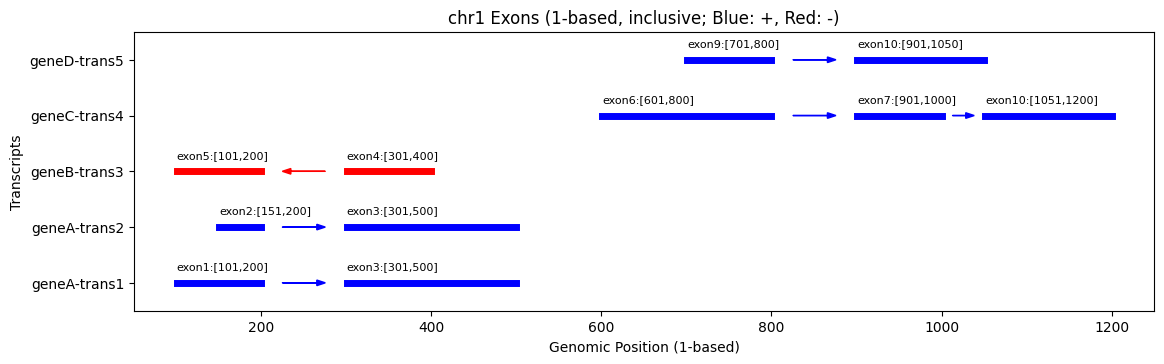

In [13]:
chrom_plt("chr1")

## Current Issues

### Double Counting

- Paired End reads are from the same transcript.
- If reads are in the same exon, that exon will get 2 count instead of 1!

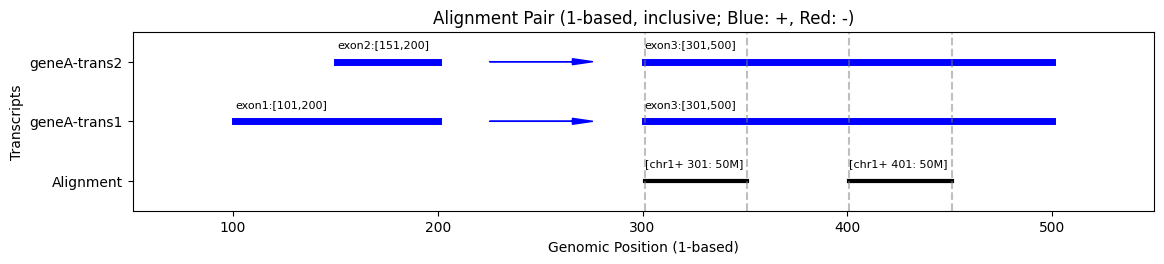

In [14]:
algn_pair_plt([
    create_fake_alignment("junction_read", "chr1", "-", 401, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 301, "50M"),
])

In [15]:
counter = Counter()
mod.count_read(
  create_fake_alignment("junction_read", "chr1", "-", 401, "50M"),
  create_fake_alignment("exon_read", "chr1", "+", 301, "50M"),
  exons, counter)
counter

Counter({'geneA-exon3': 2})

In [16]:
counter = Counter()
count_pair_with_junctions(
  [create_fake_alignment("junction_read", "chr1", "-", 401, "50M"),
  create_fake_alignment("exon_read", "chr1", "+", 301, "50M")],
  exons, exon_gene_dict, counter)
counter

Counter({'geneA-exon3': 1.0})

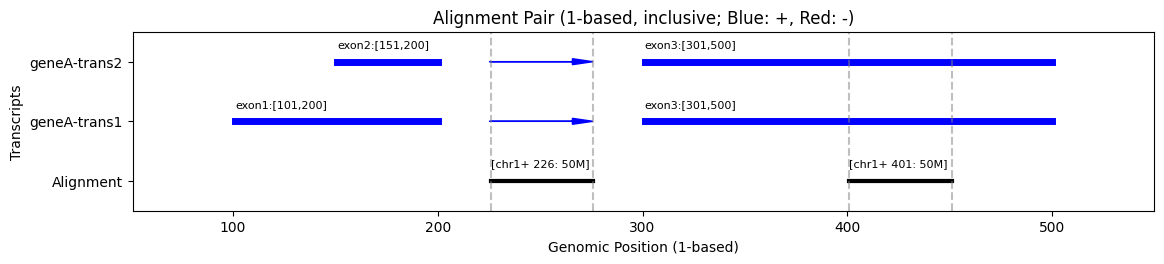

In [17]:
algn_pair_plt([
    create_fake_alignment("junction_read", "chr1", "-", 401, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 226, "50M"),
])

In [18]:
counter = Counter()
mod.count_read(
  create_fake_alignment("junction_read", "chr1", "-", 401, "50M"),
  create_fake_alignment("exon_read", "chr1", "+", 226, "50M"),
  exons, counter)
counter

Counter({'_no_feature': 1, 'geneA-exon3': 1.0})

In [19]:
counter = Counter()
count_pair_with_junctions(
  [create_fake_alignment("junction_read", "chr1", "-", 401, "50M"),
  create_fake_alignment("exon_read", "chr1", "+", 301, "50M")],
  exons, exon_gene_dict, counter)
counter

Counter({'geneA-exon3': 1.0})

Should we count in this scenario?

If we count it, why the reads overlap with both exon and intron are discarded?

## Ambigously count definite pairs

In the example below, the PE reads are from exon1, but exon2 also get counted.

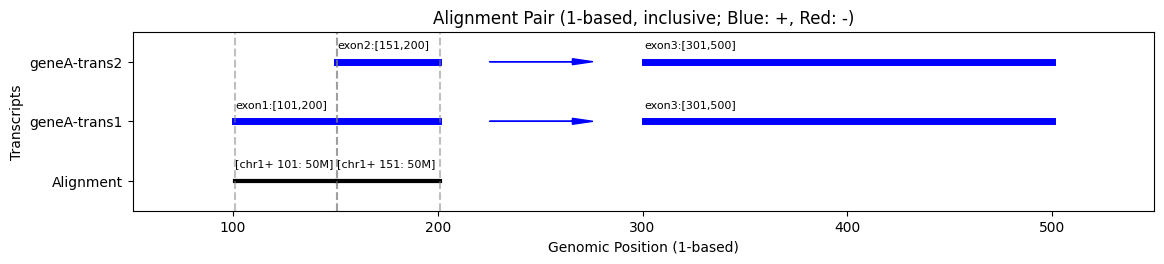

In [20]:
algn_pair_plt([
    create_fake_alignment("junction_read", "chr1", "-", 151, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 101, "50M"),
])

In [21]:
counter = Counter()
mod.count_read(
    create_fake_alignment("junction_read", "chr1", "-", 151, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 101, "50M"),
    exons, counter)
counter

Counter({'geneA-exon1': 1.5, np.str_('geneA-exon2'): 0.5})

In [22]:
counter = Counter()
count_pair_with_junctions(
    [create_fake_alignment("junction_read", "chr1", "-", 151, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 101, "50M")],
    exons, exon_gene_dict, counter)
counter

Counter({'geneA-exon1': 1.0})

### Junction Reads will be discarded

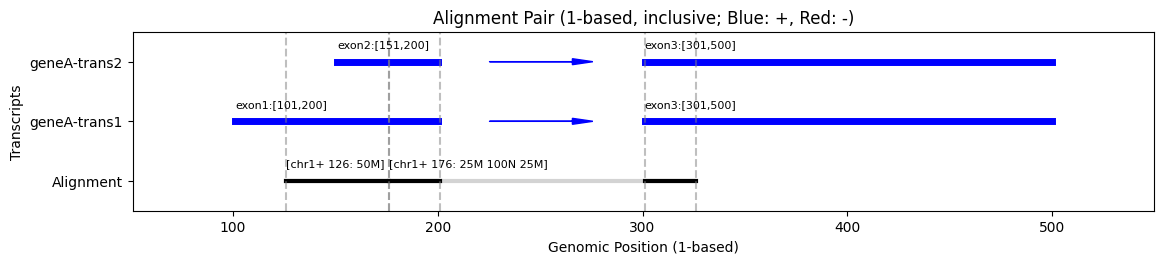

In [23]:
algn_pair_plt([
    create_fake_alignment("junction_read", "chr1", "-", 176, "25M100N25M"),
    create_fake_alignment("exon_read", "chr1", "+", 126, "50M"),
])

In [24]:
counter = Counter()
mod.count_read(
    create_fake_alignment("junction_read", "chr1", "-", 176, "25M100N25M"),
    create_fake_alignment("exon_read", "chr1", "+", 126, "50M"),
    exons, counter)
counter

Counter({'_no_feature': 1, 'geneA-exon1': 1.0})

In [25]:
counter = Counter()
count_pair_with_junctions(
    [create_fake_alignment("junction_read", "chr1", "-", 176, "25M100N25M"),
    create_fake_alignment("exon_read", "chr1", "+", 126, "50M")],
    exons, exon_gene_dict, counter)
counter

Counter({'geneA-exon1': 1.0, 'geneA-exon3': 1.0})

## Other Tests

### Ambigous Reads

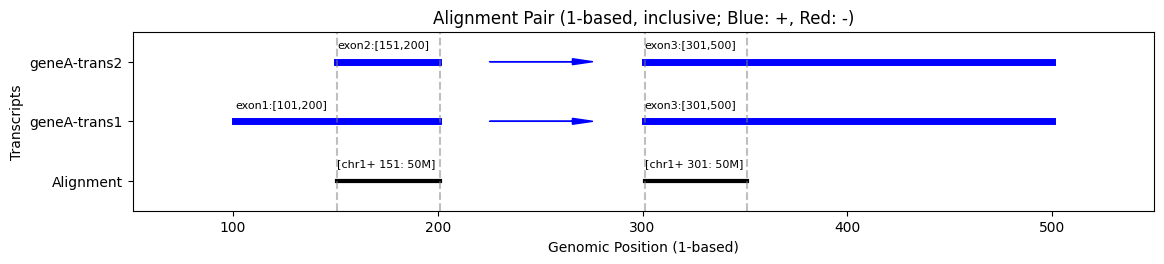

In [26]:
algn_pair_plt([
    create_fake_alignment("junction_read", "chr1", "-", 301, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 151, "50M"),
])

In [27]:
counter = Counter()
mod.count_read(
    create_fake_alignment("junction_read", "chr1", "-", 301, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 151, "50M"),
    exons, counter)
counter

Counter({'geneA-exon3': 1,
         np.str_('geneA-exon2'): 0.5,
         np.str_('geneA-exon1'): 0.5})

In [28]:
counter = Counter()
count_pair_with_junctions(
    [create_fake_alignment("junction_read", "chr1", "-", 301, "50M"),
    create_fake_alignment("exon_read", "chr1", "+", 151, "50M")],
    exons, exon_gene_dict, counter)
counter

Counter({'geneA-exon2': 0.5, 'geneA-exon1': 0.5, 'geneA-exon3': 1.0})

### Two junction reads

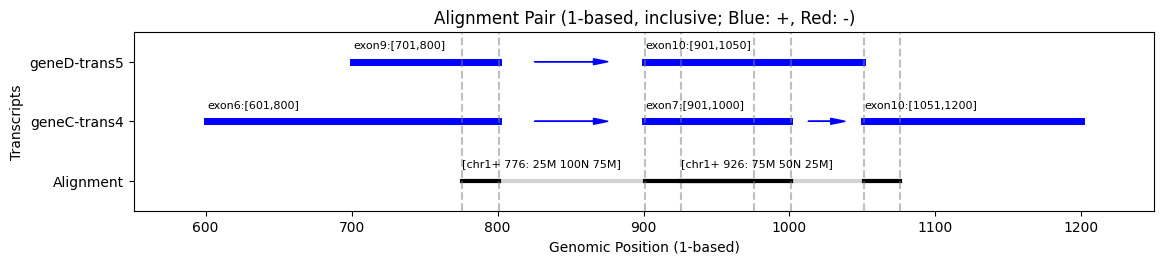

In [29]:
algn_pair_plt([
    create_fake_alignment("junction_read", "chr1", "-", 926, "75M50N25M"),
    create_fake_alignment("exon_read", "chr1", "+", 776, "25M100N75M"),
])

In [30]:
counter = Counter()
mod.count_read(
    create_fake_alignment("junction_read", "chr1", "-", 926, "75M50N25M"),
    create_fake_alignment("exon_read", "chr1", "+", 776, "25M100N75M"),
    exons, counter)
counter

Counter({'_no_feature': 2})

In [31]:
counter = Counter()
count_pair_with_junctions(
    [create_fake_alignment("junction_read", "chr1", "-", 926, "75M50N25M"),
    create_fake_alignment("exon_read", "chr1", "+", 776, "25M100N75M")],
    exons, exon_gene_dict, counter)
counter

Counter({'geneC-exon7': 1.0, 'geneC-exon6': 1.0, 'geneC-exon10': 1.0})